# About the data

Dataset description: 

The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

The goal is to identify fraudulent credit card transactions. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from datetime import datetime
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 

from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC



%matplotlib inline


In [2]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
df.shape

(284807, 31)

In [4]:
df.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

There is a class imbalance problem here. We can address the class imbalance in two ways. We can downsample the majority class, or upsample the minority class.  Downsampling is going to be a much smaller dataset.

In [3]:
# Separate majority and minority classes
df_majority = df[df.Class==0]
df_minority = df[df.Class==1]

# Downsampling

In [4]:
# Downsample majority class# Downs 
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=len(df_minority))    # to match minority class
                                
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.Class.value_counts()

1    492
0    492
Name: Class, dtype: int64

In [8]:
df_downsampled.shape

(984, 31)

In [5]:
X = df_downsampled.loc[:, ~df_downsampled.columns.isin(['Class'])]
Y = df_downsampled['Class']

X.shape, Y.shape

((984, 30), (984,))

In [125]:
# Check the Correlation Matrix for the features

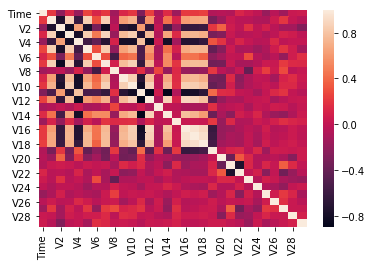

In [124]:
corr_mat = X.corr()
sns.heatmap(corr_mat)
plt.show()

Looks like many features are highly correlated. So need to do PCA.

In [6]:
X_std = StandardScaler().fit_transform(X)
pca = PCA(n_components=30)
X_pca = pd.DataFrame(pca.fit_transform(X_std))

print(
    'The percentage of total variance in the dataset explained by each component from Sklearn PCA.\n',
    pca.explained_variance_ratio_.cumsum()
)

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [ 0.37010876  0.46366491  0.55283751  0.61774574  0.66896152  0.71823097
  0.75503886  0.78889489  0.8188061   0.8452916   0.87055963  0.89150659
  0.90954435  0.9255025   0.93901938  0.9502941   0.96039183  0.96838082
  0.97456874  0.98003885  0.98384842  0.98705233  0.98985816  0.99248434
  0.99444797  0.99610269  0.9976125   0.99900282  0.99985126  1.        ]


Lets consider we want features which can explain 92% variance

In [7]:
pca = PCA(n_components=15)
X_pca = pd.DataFrame(pca.fit_transform(X_std))

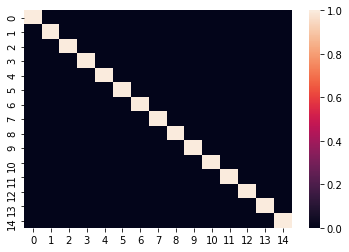

In [111]:
corr_mat = X_pca.corr()
sns.heatmap(corr_mat)
plt.show()

In [8]:
X_train, X_test, Y_train , Y_test = train_test_split(X_pca,Y,test_size=0.2, stratify = Y )
print(X_train.shape)
print(X_test.shape)

(787, 15)
(197, 15)


In [12]:
bnb = BernoulliNB()
Y_pred = cross_val_predict(bnb, X_train, Y_train, cv=5)
#print(Y_pred.shape)
bnb_train_precision, bnb_train_recall, thresholds = precision_recall_curve(Y_train, Y_pred)

print(auc(bnb_train_precision, bnb_train_recall))

conf_mat = confusion_matrix(Y_train, Y_pred)
#print(conf_mat)
print('Precision from Confusion Matrix ', conf_mat[1,1] / (conf_mat[1,1]+conf_mat[0,1]) )
print('Recall from Confusion Matrix ', conf_mat[1,1] / (conf_mat[1,1]+conf_mat[1,0]) )


0.425162558719
Precision from Confusion Matrix  0.944117647059
Recall from Confusion Matrix  0.814720812183


In [14]:
start = datetime.now()
Y_pred = cross_val_predict(bnb, X_test, Y_test, cv=5)

bnb_test_precision, bnb_test_recall, thresholds = precision_recall_curve(Y_test, Y_pred)


print(auc(bnb_test_precision, bnb_test_recall))

conf_mat = confusion_matrix(Y_test, Y_pred)
bnb_runtime = datetime.now() - start
print('Duration : ',bnb_runtime )

print('Precision from Confusion Matrix ', conf_mat[1,1] / (conf_mat[1,1]+conf_mat[0,1]) )
print('Recall from Confusion Matrix ', conf_mat[1,1] / (conf_mat[1,1]+conf_mat[1,0]) )

0.412316766808
Duration :  0:00:00.015626
Precision from Confusion Matrix  0.9375
Recall from Confusion Matrix  0.765306122449


# Try with  Logistic Regression

In [39]:
logreg = LogisticRegression()
Y_pred = cross_val_predict(logreg, X_train, Y_train, cv=5)

logreg_train_precision, logreg_train_recall, thresholds = precision_recall_curve(Y_train, Y_pred)

print(auc(logreg_train_precision, logreg_train_recall))


0.459107671526


In [17]:
start = datetime.now()

Y_pred = cross_val_predict(logreg, X_test, Y_test, cv=5)
#print(Y_pred.shape)
logreg_test_precision, logreg_test_recall, thresholds = precision_recall_curve(Y_test, Y_pred)

print(auc(logreg_test_precision, logreg_test_recall))


logreg_runtime = datetime.now() - start
print('Duration : ',logreg_runtime )

0.458126143859
Duration :  0:00:00.015624


# Try Lasso Regression

In [18]:
lasso = LogisticRegressionCV(penalty='l1', solver = 'liblinear')
Y_pred = cross_val_predict(lasso, X_train, Y_train, cv=5)

lasso_train_precision, lasso_train_recall, thresholds = precision_recall_curve(Y_train, Y_pred)

print(auc(lasso_train_precision, lasso_train_recall))


0.454257937864


In [19]:
start = datetime.now()

Y_pred = cross_val_predict(lasso, X_test, Y_test, cv=5)

lasso_test_precision, lasso_test_recall, thresholds = precision_recall_curve(Y_test, Y_pred)

print(auc(lasso_test_precision, lasso_test_recall))

lasso_runtime = datetime.now() - start
print('Duration : ',lasso_runtime )

0.444297906589
Duration :  0:00:01.223498


In [126]:
lasso.fit(X_train, Y_train)

print(lasso.coef_)

[[ 2.15363497 -0.33725936  0.35906563 -0.71364875 -1.81406276  0.91272739
  -0.38515949  0.21378339 -0.48616278  0.47524876  0.57004078 -0.71998489
   0.16580282  1.69394127 -0.31835182]]


In [42]:
lasso_params = lasso.coef_
len(lasso_params[lasso_params ==0])

8

# Try KNN

In [20]:
knn = KNeighborsClassifier()
# Set of parameters to test for best score in Grid Search CV
k = np.arange(2,15,1)
parameters = {'n_neighbors':k}

#fitting model and printing best parameters and score from model
grid_knn = GridSearchCV(knn, param_grid=parameters, scoring='recall')
grid_knn.fit(X_train, Y_train)

print('Best Score:', grid_knn.best_score_)
best_params_knn = grid_knn.best_params_
print('Best Parameters:', best_params_knn)



Best Score: 0.873127719379
Best Parameters: {'n_neighbors': 3}


In [21]:
start = datetime.now()

knn = KNeighborsClassifier(n_neighbors = 3)
Y_pred = cross_val_predict(knn, X_train, Y_train, cv=5)

knn_train_precision, knn_train_recall, thresholds = precision_recall_curve(Y_train, Y_pred)

print(auc(knn_train_precision, knn_train_recall))

knn_runtime = datetime.now() - start
print('Duration : ',knn_runtime )

0.451524679095
Duration :  0:00:00.046875


In [34]:
start = datetime.now()
Y_pred = cross_val_predict(knn, X_test, Y_test, cv=5)
knn_test_precision, knn_test_recall, thresholds = precision_recall_curve(Y_test, Y_pred)

print(auc(knn_test_precision, knn_test_recall))

knn_runtime = datetime.now() - start
print('Duration : ',knn_runtime )

0.403502797058
Duration :  0:00:00.015626


# Try Decision Tree

In [22]:
start_time = datetime.now()
params = {'max_depth': [3, 4, 5, 6, 7, None],
          'max_features':[1,2,3,4]
         }
gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                  param_grid=params,
                  scoring='recall',
                  cv=5)

gs = gs.fit(X_train, Y_train)

print("Duration : ", (datetime.now() - start_time))

print(gs.best_score_)
print(gs.best_params_)

Duration :  0:00:00.506426
0.885754266321
{'max_depth': None, 'max_features': 4}


In [23]:
start = datetime.now()

decision_tree = DecisionTreeClassifier(**gs.best_params_ , random_state=0)
Y_pred = cross_val_predict(decision_tree, X_train, Y_train, cv=5)

decision_tree_train_precision, decision_tree_train_recall, thresholds = precision_recall_curve(Y_train, Y_pred)

print(auc(decision_tree_train_precision, decision_tree_train_recall))
dt_runtime = datetime.now() - start
print('Duration : ',dt_runtime )

0.397498024434
Duration :  0:00:00.031250


In [36]:
start = datetime.now()

Y_pred = cross_val_predict(decision_tree, X_test, Y_test, cv=5)
decision_tree_test_precision, decision_tree_test_recall, thresholds = precision_recall_curve(Y_test, Y_pred)

print(auc(decision_tree_test_precision, decision_tree_test_recall))

decision_tree_runtime = datetime.now() - start
print('Duration : ',decision_tree_runtime )

0.337583595198
Duration :  0:00:00.034271


# Try Random Forest

In [24]:
start_time = datetime.now()
rfc_params  = {
    'n_estimators':[100,200,500],
    'max_features':['auto', 'sqrt', 'log2'],
    'max_depth':[4, 6,7, 8, None],
    'min_samples_split':[2, 8]
}
rfc_grid = GridSearchCV(RandomForestClassifier(random_state=0), param_grid=rfc_params, cv=5)
rfc_grid.fit(X_train, Y_train)

print("Duration : ", (datetime.now() - start_time))

print(rfc_grid.best_score_)
print(rfc_grid.best_params_)

Duration :  0:03:41.329810
0.92376111817
{'max_depth': 4, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 500}


In [25]:
forest = RandomForestClassifier(**rfc_grid.best_params_ , random_state=42)

Y_pred = cross_val_predict(forest, X_train, Y_train, cv=5)


rfc_train_precision, rfc_train_recall, thresholds = precision_recall_curve(Y_train, Y_pred)

print(auc(rfc_train_precision, rfc_train_recall))

0.454394935572


In [26]:
start = datetime.now()

Y_pred = cross_val_predict(forest, X_test, Y_test, cv=5)
rfc_test_precision, rfc_test_recall, thresholds = precision_recall_curve(Y_test, Y_pred)

print(auc(rfc_test_precision, rfc_test_recall))

rfc_runtime = datetime.now() - start
print('Duration : ',rfc_runtime )

0.444191493609
Duration :  0:00:02.709257


# Try SVC

In [28]:
svc = SVC()
start_time = datetime.now()
parameters = [{'kernel':['rbf'], 'C': [0.1,1,10], 'gamma':[0.0001,0.001]},
              {'kernel':['linear'], 'C': [0.1,1,10]}]
#fitting model and printing best parameters and score from model
grid = GridSearchCV(svc, param_grid=parameters)
grid.fit(X_train, Y_train)
print(grid.best_params_)
print(grid.best_score_)
#recording time model finished and printing overall time to run model
print("Duration : ", (datetime.now() - start_time))

{'C': 10, 'kernel': 'linear'}
0.925031766201
Duration :  0:00:00.593773


In [29]:
svc = SVC(**grid.best_params_ , random_state=42)

Y_pred = cross_val_predict(svc, X_train, Y_train, cv=5)


svc_train_precision, svc_train_recall, thresholds = precision_recall_curve(Y_train, Y_pred)

print(auc(svc_train_precision, svc_train_recall))

0.456270466795


In [30]:
start = datetime.now()
Y_pred = cross_val_predict(svc, X_test, Y_test, cv=5)
svc_test_precision, svc_test_recall, thresholds = precision_recall_curve(Y_test, Y_pred)

print(auc(svc_test_precision, svc_test_recall))

svc_runtime = datetime.now() - start
print('Duration : ',svc_runtime )


0.415069403134
Duration :  0:00:00.031251


# Precision Recall Curve for all Models

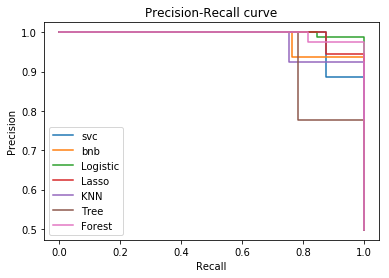

In [41]:
plt.step(svc_test_recall, svc_test_precision, label = 'svc')
plt.step(bnb_test_recall, bnb_test_precision, label = 'bnb')
plt.step(logreg_test_recall, logreg_test_precision, label ='Logistic')
plt.step(lasso_test_recall, lasso_test_precision, label ='Lasso')
plt.step(knn_test_recall, knn_test_precision, label = 'KNN')
plt.step(decision_tree_test_recall, decision_tree_test_precision, label = 'Tree')
plt.step(rfc_test_recall, rfc_test_precision, label = 'Forest')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend()
plt.show()

In [46]:
runtime = [ ['Bernoulli', bnb_runtime],['logistic',logreg_runtime],
           ['svc' ,svc_runtime],['rfc',rfc_runtime],['decision tree',decision_tree_runtime],
           ['knn',knn_runtime] , ['lasso',lasso_runtime]    
]
runtime_df = pd.DataFrame(runtime, columns = ['Models','Run Time'])
runtime_df.sort_values(by = 'Run Time', ascending = False)

,Models,Run Time
3,rfc,00:00:02.709257
6,lasso,00:00:01.223498
4,decision tree,00:00:00.034271
2,svc,00:00:00.031251
0,Bernoulli,00:00:00.015626
5,knn,00:00:00.015626
1,logistic,00:00:00.015624


The Logistic Regression Took the least time.

# Conclusion

As a conclusion, Logistic Regression performed best considering the accuracy and speed. Knowing the question and this information, I would suggest that the credit card company use the Logistic Regression model with this data.